/tmp/ipython-input-4117982492.py:30: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'titanic-dataset' dataset.
Dataset Shape: (891, 12)


/tmp/ipython-input-4117982492.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Age"].fillna(df["Age"].median(), inplace=True)
/tmp/ipython-input-4117982492.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

Best Hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

=== SVM Performance ===
Accuracy: 0.8100558659217877
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       110
           1       0.84      0.62      0.72        69

    accuracy                           0.81       179
   macro avg       0.82      0.78      0.79       179
weighted avg       0.81      0.81      0.80       179



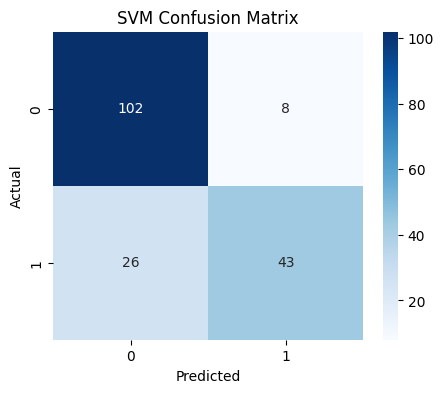

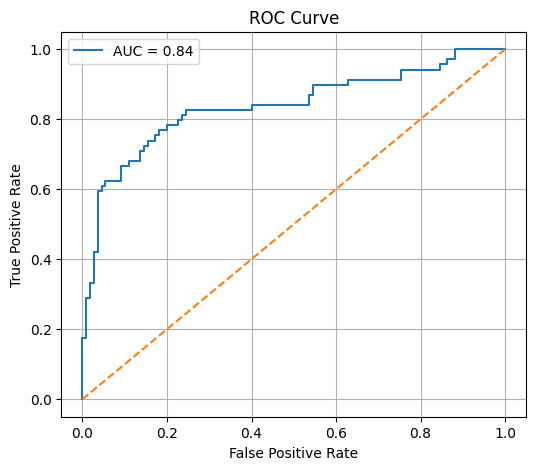

In [2]:
# ==============================
# EXPERIMENT 5
# SVM - Titanic Survival Dataset
# ==============================

!pip install kagglehub -q

import kagglehub
from kagglehub import KaggleDatasetAdapter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

# -------------------------
# Load Dataset
# -------------------------
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "yasserh/titanic-dataset",
    "Titanic-Dataset.csv"
)

print("Dataset Shape:", df.shape)

# -------------------------
# Data Preprocessing
# -------------------------

# Handle missing values
df["Age"].fillna(df["Age"].median(), inplace=True)
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)

# Encode categorical variables
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
df = pd.get_dummies(df, columns=["Embarked"], drop_first=True)

# Drop irrelevant columns
df.drop(columns=["Name", "Ticket", "Cabin", "PassengerId"], inplace=True)

# Feature & Target split
X = df.drop("Survived", axis=1)
y = df["Survived"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------
# Hyperparameter Tuning
# -------------------------
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc = SVC(probability=True, random_state=42)

grid = GridSearchCV(
    svc,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("Best Hyperparameters:", grid.best_params_)

# Final model
best_svc = grid.best_estimator_

y_pred = best_svc.predict(X_test_scaled)
y_prob = best_svc.predict_proba(X_test_scaled)[:, 1]

# -------------------------
# Evaluation
# -------------------------
print("\n=== SVM Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
